## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [44]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [45]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# to use regular expressions for manipulating text data
import re

# to manipulate string data
import string

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
# nltk.download('punkt')    # loading the punkt module used in tokenization
# nltk.download('omw-1.4')    # dependency for tokenization
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# To tune different models
from sklearn.model_selection import GridSearchCV

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# To import Word2Vec
from gensim.models import Word2Vec

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the dataset**

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
stock=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 6/stock_news.csv')

In [48]:
data=stock.copy()

## **Data Overview**

In [49]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [50]:
data.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influencing millions with her opinions on diets and books, is considering which Democratic presidential candidate to endorse in 2020. She told the Hollywood Reporter she's ""quietly figuring out where I'm going to use my voice"" and will make a clear announcement",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks underperforming amid a decline in China's manufacturing activity and awaiting euro zone economic growth numbers. The pan-European STOXX 600 index dropped 0.7% while major indices fell except London's FTSE 100. Danske Bank plunged",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,"This article reports that the S&P 500 reached another record high close on Tuesday, marking its best four-month stretch since late 2010. Apple's strong quarterly results and positive earnings forecast helped ease concerns about the bull run's sustainability, despite a revenue miss from Google parent Alphabet. The",50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,"The Federal Reserve is anticipated to keep interest rates unchanged in their upcoming meeting, with a likelihood of a rate cut expected later this year. The Fed Chairman's press conference may provide significant market impact as investors seek insights on economic growth and inflation. Apple's earnings report exceeded expectations, leading to a post-market surge in shares, while",50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung Electronics reported its weakest profit in over two years due to falls in chip prices and slowing demand for display panels. The tech giant expects improved results in the second half of 2019, driven by a pickup in memory chip and smartphone sales. However, memory chip",50.764999,50.849998,49.7775,48.70879,186139600,0


* From the several samples that we displayed we can see that the actual News content present in the dataset looks truncated - we do not have the whole text of the News

In [51]:
print("The dataset contains {} rows and {} columns".format(data.shape[0],data.shape[1]))

The dataset contains 349 rows and 8 columns


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* we need to convert the Date column into the proper datetime format

In [53]:
data['Date']=pd.to_datetime(data['Date'])

In [54]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.0,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


* It is a bit strange that the minimum value for the 'Close' column is lower than the minimum value for the 'Low' column. This needs to be discussed with the domain expert

In [55]:
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


* There are no null values in the dataset

In [56]:
data.duplicated().sum()

0

* There are no duplicate values in the dataset

## **Exploratory Data Analysis**

### Utility functions

In [ ]:
# function to plot a histogram

def histogram(data, feature, figsize=(12, 7), kde=False):
    """
    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    """
    plt.figure(figsize=figsize)
    sns.histplot(
        data=data, x=feature, kde=kde
    )
    plt.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    plt.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        #palette="Paired",
        legend=False,
        #order=data[feature].value_counts().index[:n].sort_values(),
        order=data[feature].value_counts().index[:n]
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [ ]:
print("Earliest date in the dataset: {}\nLatest data in the dataset: {}".format(data['Date'].min().date(),data['Date'].max().date()))

Earliest date in the dataset: 2019-01-02
Latest data in the dataset: 2019-04-30


In [ ]:
num_cols=['Open', 'High', 'Low', 'Close', 'Volume']

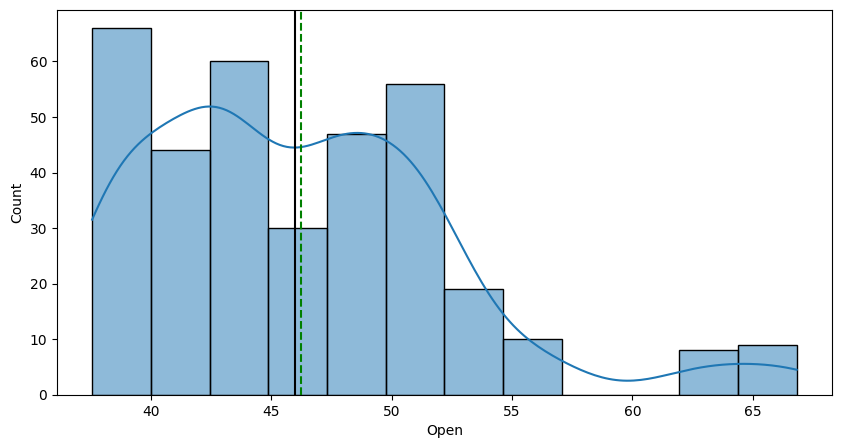

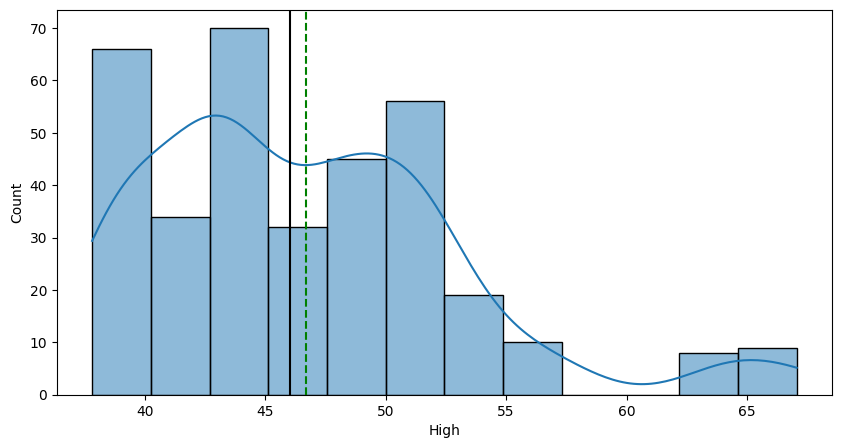

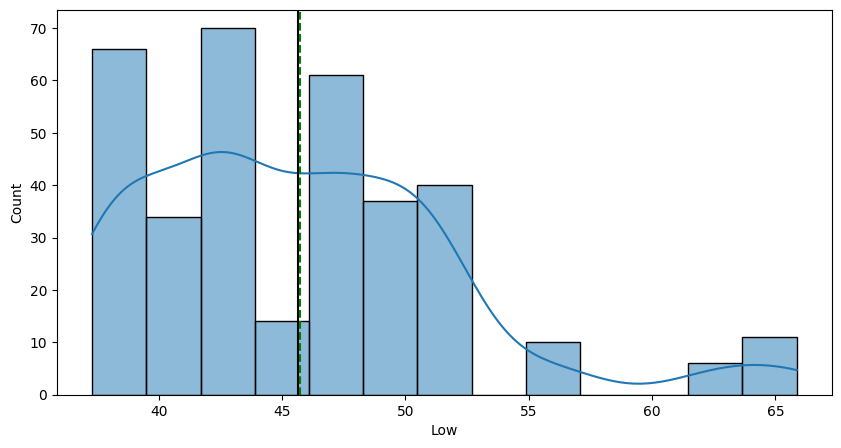

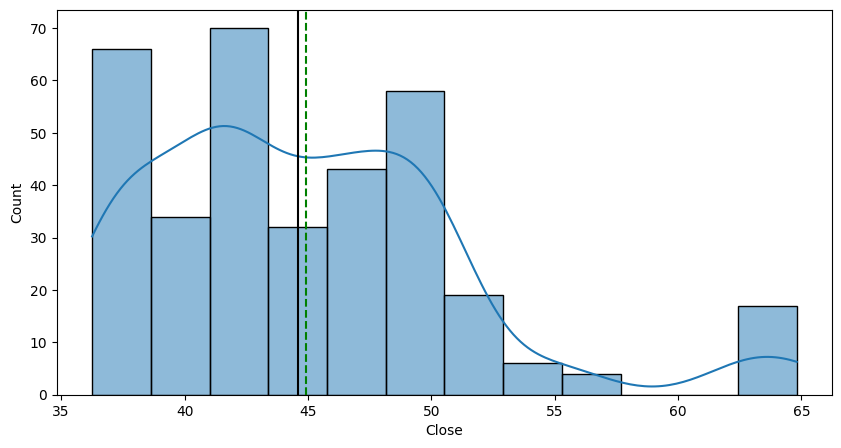

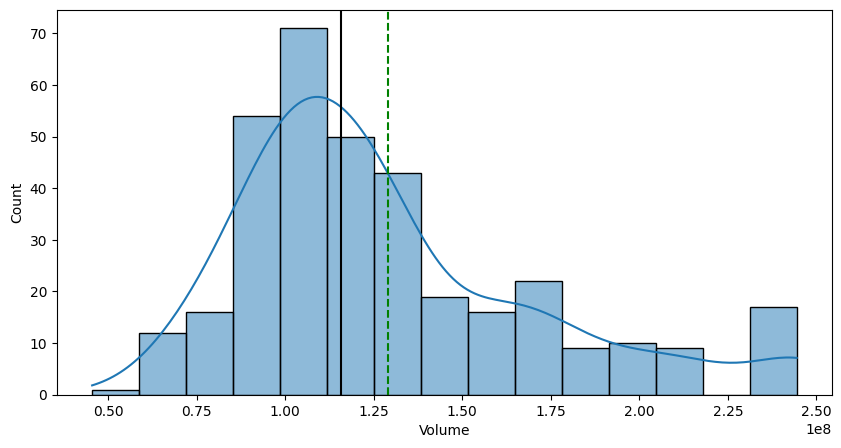

In [ ]:
for col in num_cols:
  histogram(data, col, figsize=(10,5), kde=True)

* All the stock prices have very similar distribution
* Distibution of Volume is slightly right-skewed

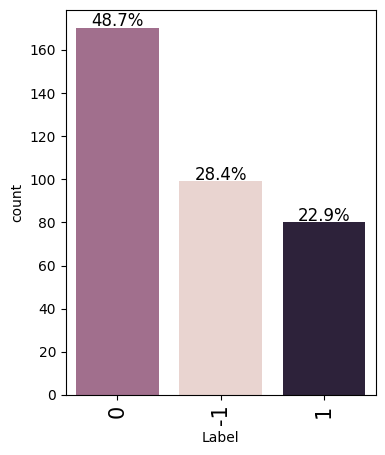

In [ ]:
labeled_barplot(data, 'Label', perc = True)

* Almost half of the news articles are neutral
* There are a bit more negative articles than positive

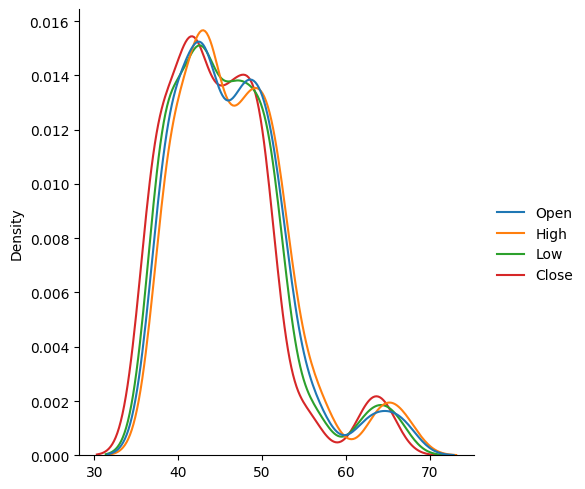

In [ ]:
sns.displot(data=stock[["Open","High","Low","Close"]], kind="kde", palette="tab10");

* This confirms the above observation - the distribution of Open, High, Low and Close stocl prices are almost identical

In [ ]:
## Calculating the length of the news content (number of words)
data['News_Length_Words'] = data['News'].apply(lambda x: len(x.split(' ')))

## Calculating the overall length of news content
data['News_Length'] = data['News'].apply(len)

In [ ]:
data[['News_Length_Words','News_Length']].describe().T

,count,mean,std,min,25%,50%,75%,max
News_Length_Words,349.0,49.312321,5.727770,19.0,46.0,50.0,53.0,61.0
News_Length,349.0,311.237822,39.079467,110.0,290.0,315.0,336.0,394.0


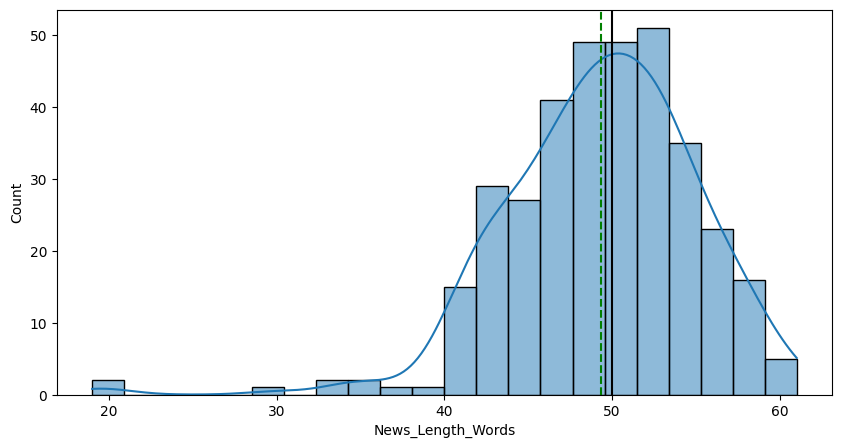

In [ ]:
histogram(data, 'News_Length_Words', figsize=(10,5),kde=True)

* 75% of the news are between 46 and 61 words. The rest are shorter than 46 words.

### Bivariate Analysis

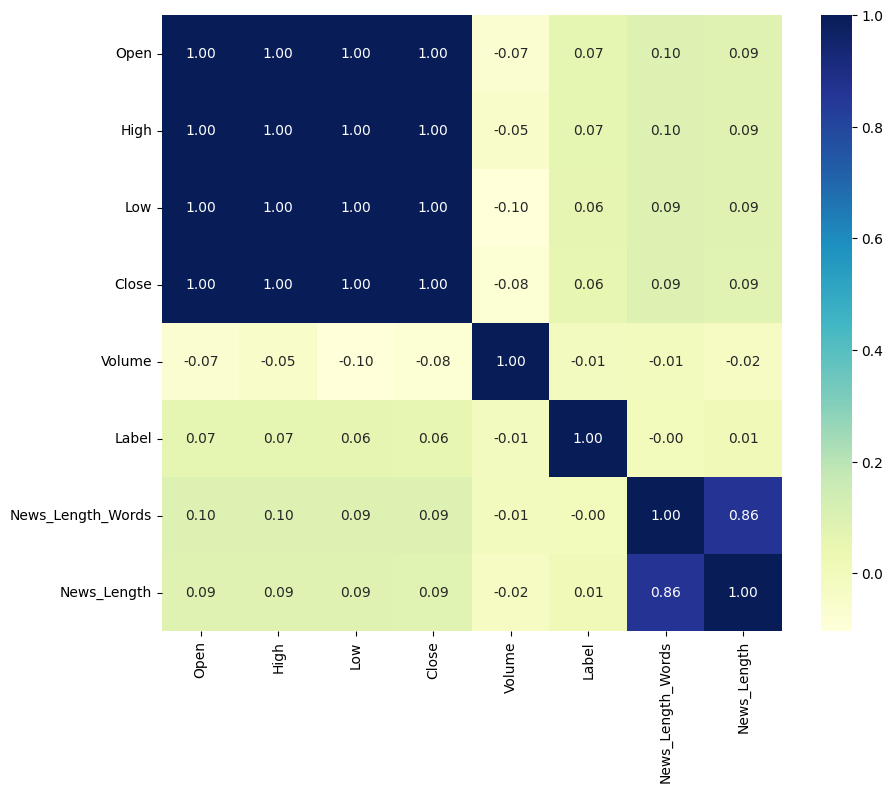

In [ ]:
## Heatmap of the correlation matrix between the variables
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True),fmt=".2f",annot=True,cmap="YlGnBu")
plt.show()

* We can see perfect correlation between the prices

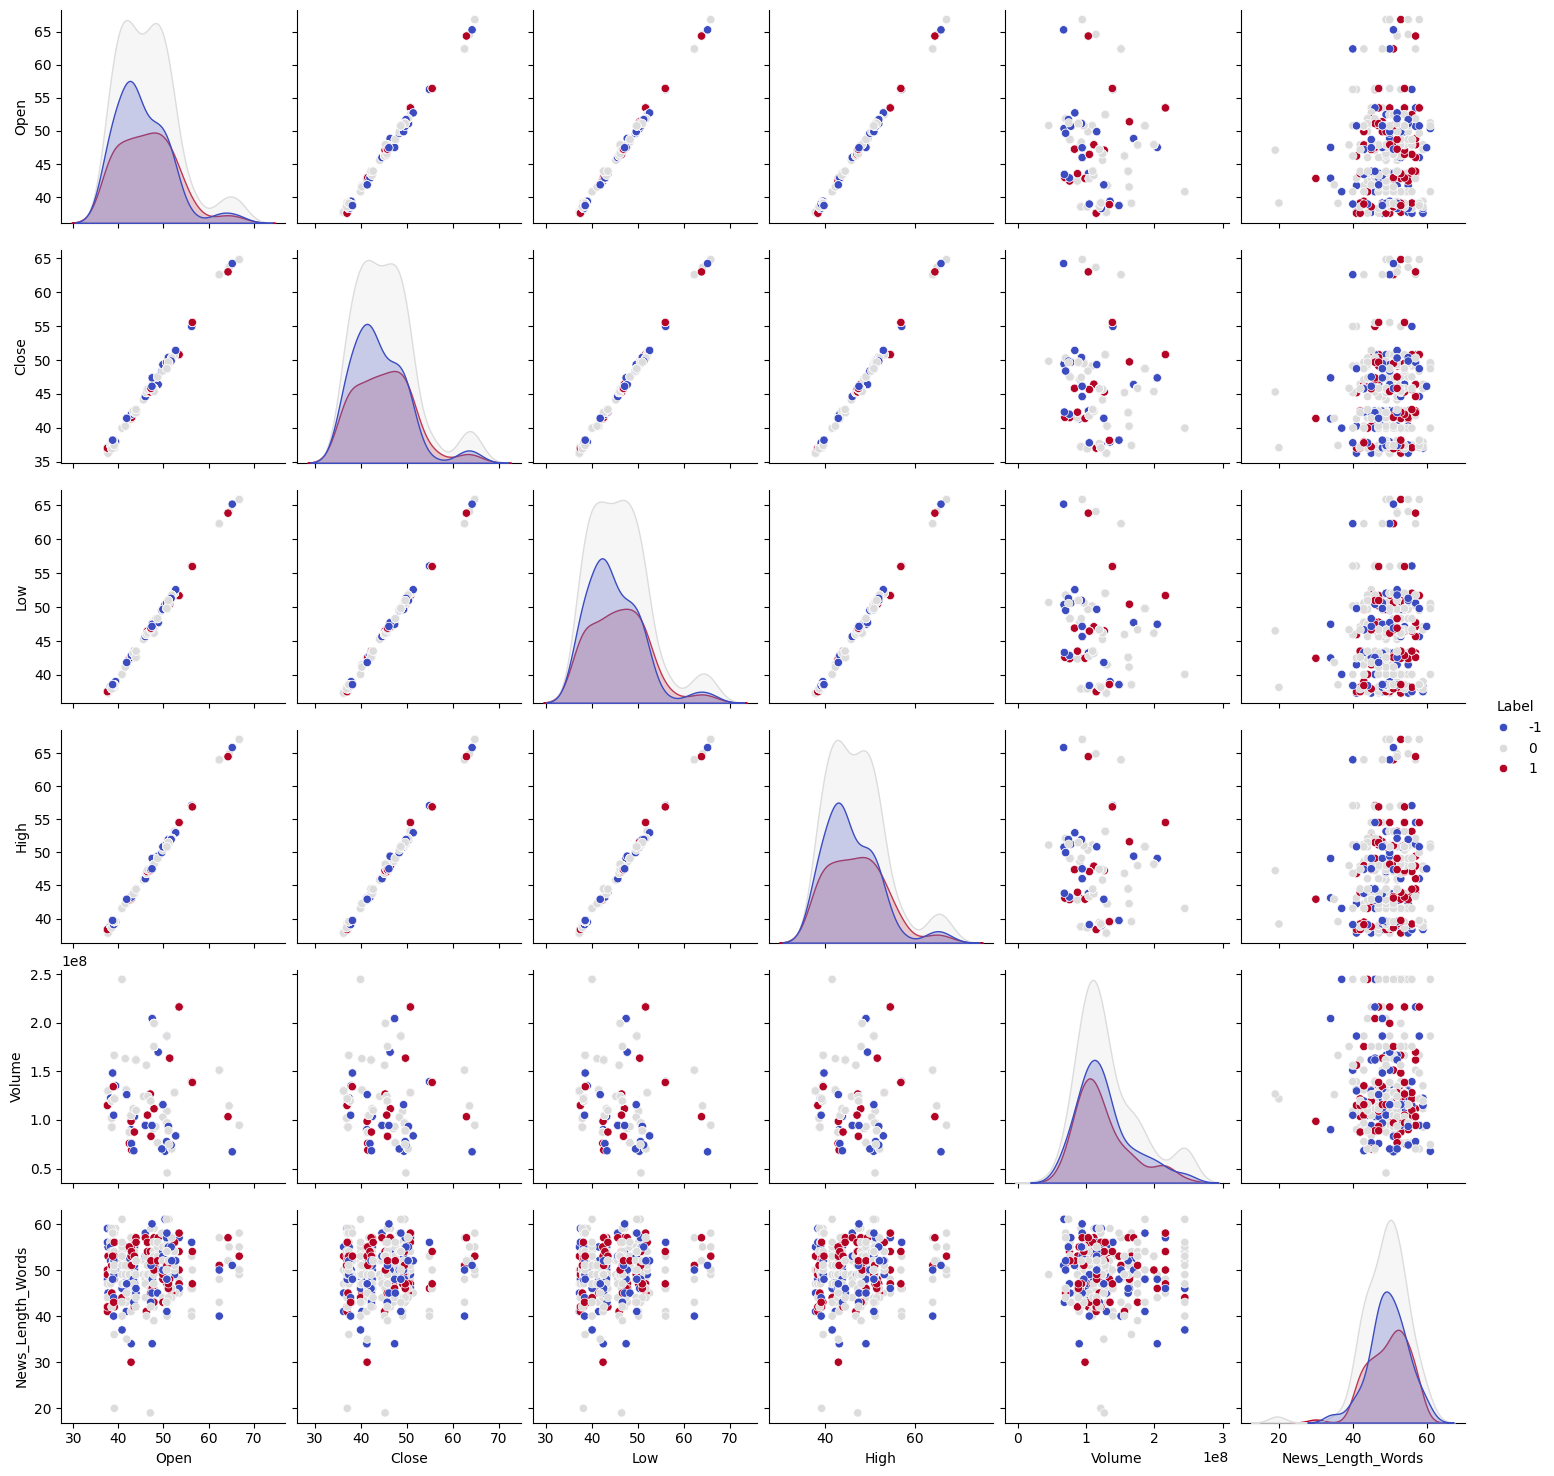

In [ ]:
# Pairplot to visualize relationships between variables
sns.pairplot(data[['Open','Close','Low','High','Volume','News_Length_Words','Label']], hue='Label', palette='coolwarm')
plt.show()

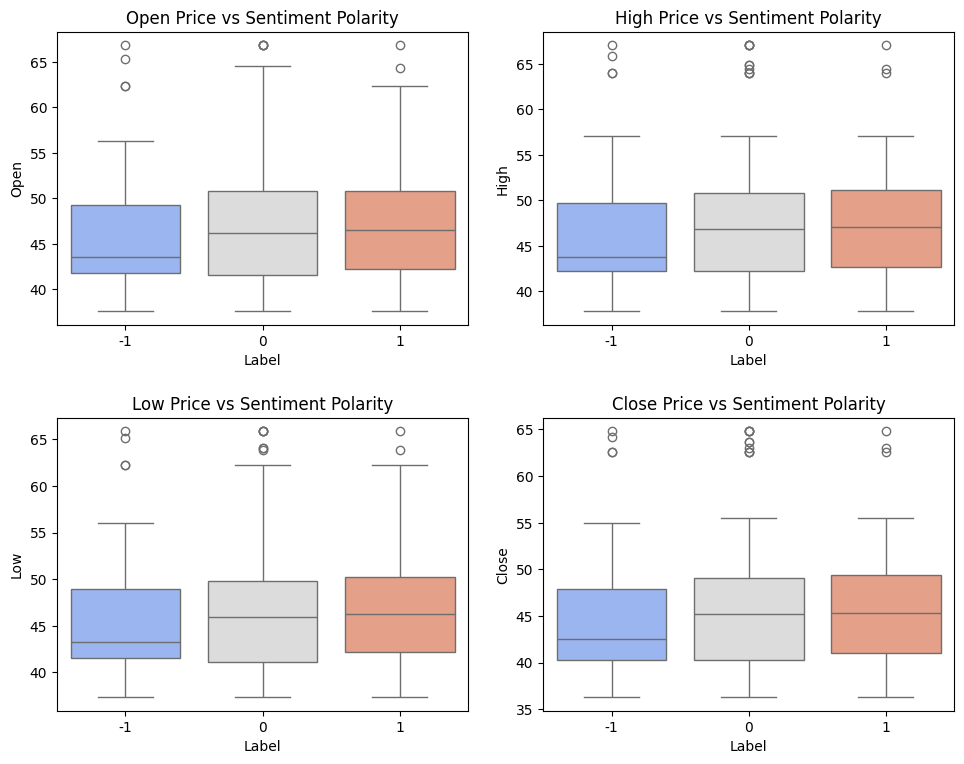

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable, palette='coolwarm')
    plt.title(variable+' Price vs Sentiment Polarity')
    plt.tight_layout(pad=2)

plt.show()

* We can see the logically expected correlaction that on the negative sentiment the price is lower, but there is no significant increase in the price on the positive sentiment

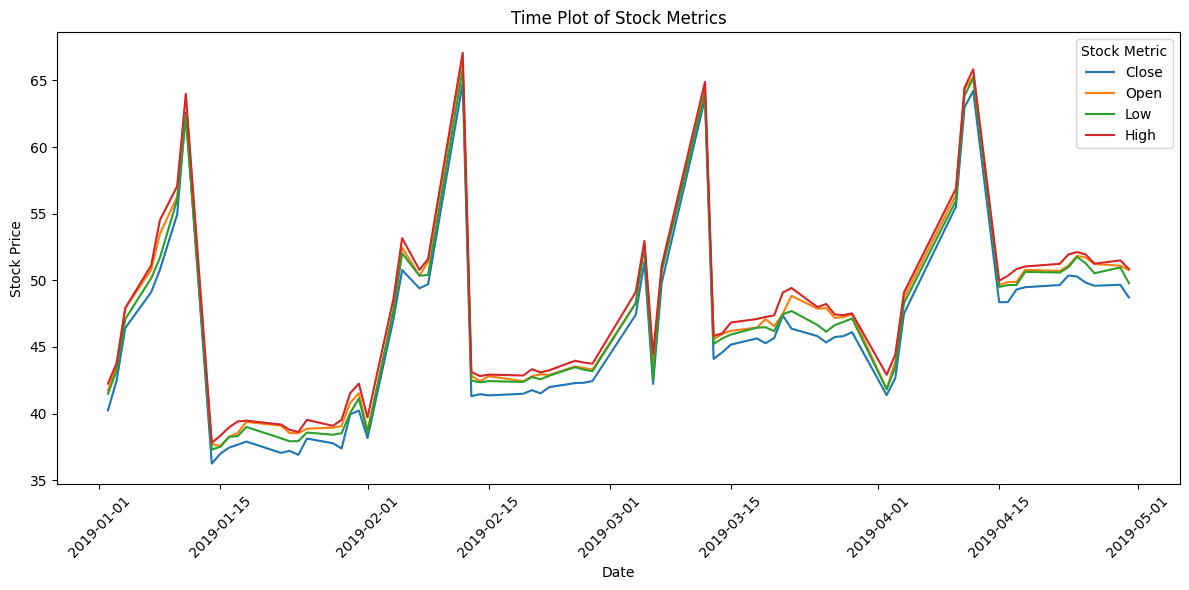

In [ ]:
# Reshape the data using the melt function
melted_data = pd.melt(data, id_vars=['Date'], value_vars=['Close', 'Open', 'Low', 'High'],
                      var_name='Stock Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_data, x='Date', y='Value', hue='Stock Metric')

plt.title('Time Plot of Stock Metrics')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(title='Stock Metric')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout for better fit
plt.show()

* We can see regular very high spikes and subsequent huge drops in the stock price which happen closer to the middle of each month

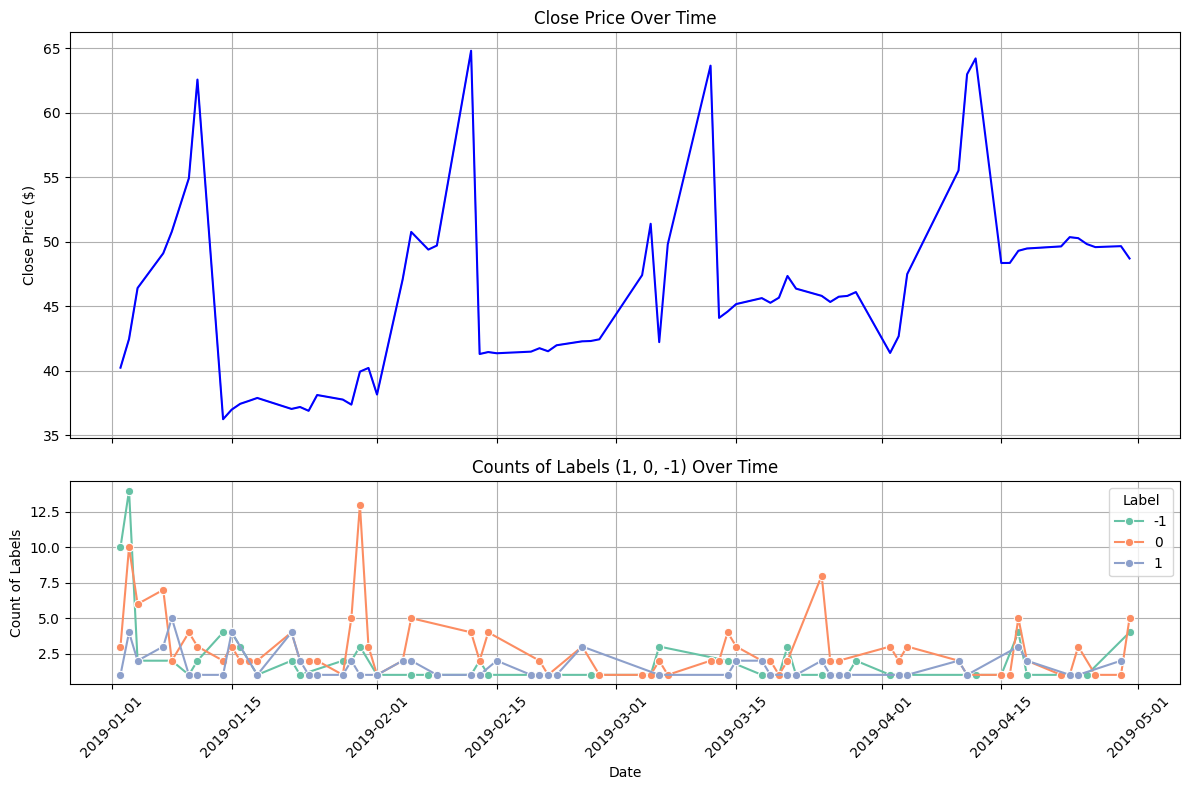

In [ ]:
# Prepare data for the count of labels per date
label_counts = data.groupby(['Date', 'Label']).size().reset_index(name='Count')

# Create the figure and the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the 'Close' price over time
sns.lineplot(data=data, x='Date', y='Close', ax=ax1, color='blue')
ax1.set_title('Close Price Over Time')
ax1.set_ylabel('Close Price ($)')
ax1.grid(True)

# Plot the count of 'Label' values over time with different colors for each label
sns.lineplot(data=label_counts, x='Date', y='Count', hue='Label', ax=ax2, palette='Set2', marker='o')
ax2.set_title('Counts of Labels (1, 0, -1) Over Time')
ax2.set_ylabel('Count of Labels')
ax2.set_xlabel('Date')
ax2.grid(True)

# Rotate x-ticks for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* For some of the price drops we can see that they correlate with increase of printed negative news.
* However, steep price increases do not appear to correlate with increase in positive news

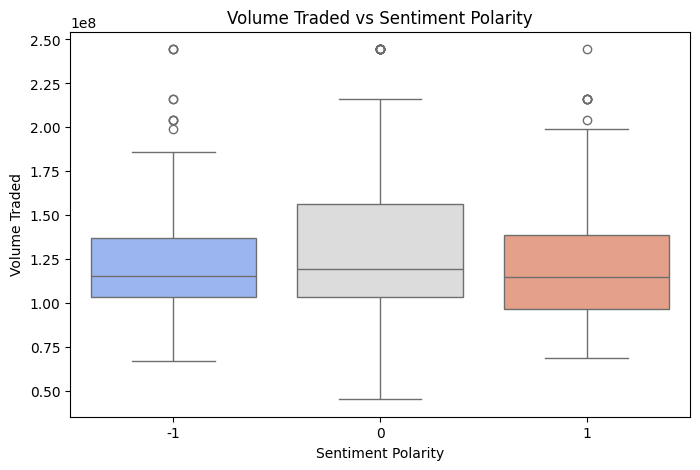

In [ ]:
# Relationship between Volume and Sentiment Polarity
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='Volume', data=data, palette='coolwarm')
plt.title('Volume Traded vs Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Volume Traded')
plt.show()

* It apears that amount of stock traded is larger if the news are neutral
* The amount of stock traded on positive and negative news seems to be comparable

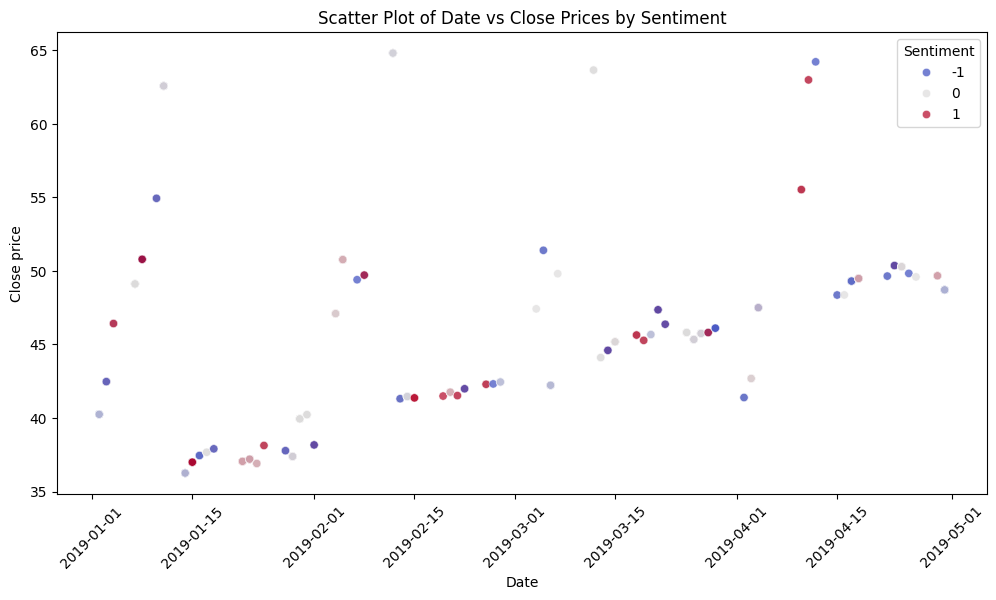

In [ ]:
# Scatter plot of Close price vs Date colored by sentiment
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Date', y='Close', hue='Label', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot of Date vs Close Prices by Sentiment')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

* Observation:

* All the stock prices have very similar distribution
* Distibution of Volume is slightly right-skewed
* Almost half of the news articles are neutral
* There are a bit more negative articles than positive
* 75% of the news are between 46 and 61 words. The rest are shorter than 46 words.
* We can see perfect correlation between the prices
* We can see the logically expected correlaction that on the negative sentiment the price is lower, but there is no significant increase in the price on the positive sentiment
* We can see regular very high spikes and subsequent huge drops in the stock price which happen closer to the middle of each month
*For some of the price drops we can see that they correlate with increase of printed negative news.
* However, steep price increases do not appear to correlate with increase in positive news
* It apears that amount of stock traded is larger if the news are neutral
* The amount of stock traded on positive and negative news seems to be comparable

## **Text preprocessing**

In [57]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [58]:
# Applying the function to remove special characters
data['cleaned_News'] = data['News'].apply(remove_special_characters)

In [59]:
# changing the case of the text data to lower case
data['cleaned_News'] = data['cleaned_News'].str.lower()

In [60]:
# removing extra whitespaces from the text
data['cleaned_News'] = data['cleaned_News'].str.strip()

In [61]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [62]:
# Applying the function to remove stop words using the NLTK library
data['cleaned_text_without_stopwords'] = data['cleaned_News'].apply(remove_stopwords)

In [63]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [64]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [65]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [66]:
# checking a couple of instances of cleaned data
data.loc[0:2,['News','final_cleaned_text']]

,News,final_cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",appl lower fiscal q1 revenu guidanc 84 billion earlier estim 89 93 billion due weaker expect iphon sale announc caus signific drop appl stock price neg impact relat supplier lead broader market declin tech indic nasdaq 10
2,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",appl cut fiscal first quarter revenu forecast 89 93 billion 84 billion due weaker demand china fewer iphon upgrad ceo tim cook also mention constrain sale airpod macbook appl share fell 8 5 post market trade asian supplier like hon


## **Data Preprocessing**

In [67]:
data['Date'].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


* We have the News data for 4 months - January, February, March and April. It makes sense to split the data into train, test and validation sets using the date.


In [68]:
X_train=data[data['Date']<'2019-04-01']['final_cleaned_text'].reset_index(drop=True)
X_val=data[(data['Date']>='2019-04-01') & (data['Date']<'2019-04-16')]['final_cleaned_text'].reset_index(drop=True)
X_test=data[data['Date']>='2019-04-16']['final_cleaned_text'].reset_index(drop=True)

In [69]:
y_train=data[data['Date']<'2019-04-01']['Label'].reset_index(drop=True)
y_val=data[(data['Date']>='2019-04-01') & (data['Date']<'2019-04-16')]['Label'].reset_index(drop=True)
y_test=data[data['Date']>='2019-04-16']['Label'].reset_index(drop=True)

In [70]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)


In [71]:
#Checking the shape of the split datasets
print("Train data {},\nValidation data {},\nTest data {},\n\nTrain target {},\nValidation target {},\nTest target {}".format(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape))

Train data (286,),
Validation data (21,),
Test data (42,),

Train target (286,),
Validation target (21,),
Test target (42,)


In [72]:
X_train.head()

,final_cleaned_text
0,tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,appl lower fiscal q1 revenu guidanc 84 billion earlier estim 89 93 billion due weaker expect iphon sale announc caus signific drop appl stock price neg impact relat supplier lead broader market declin tech indic nasdaq 10
2,appl cut fiscal first quarter revenu forecast 89 93 billion 84 billion due weaker demand china fewer iphon upgrad ceo tim cook also mention constrain sale airpod macbook appl share fell 8 5 post market trade asian supplier like hon
3,news articl report yield long date u treasuri secur hit lowest level nearli year januari 2 2019 due concern health global economi follow weak econom data china europ well partial u govern shutdown appl
4,appl revenu warn led declin usd jpi pair gain japanes yen investor sought safeti highli liquid currenc appl underperform q1 forecast revenu 84 billion compar analyst expect 91 5 billion trigger risk avers mood market


## **Word Embeddings**

###Word2Vec


In [73]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['final_cleaned_text'].values]

In [74]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [75]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [76]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 3.21693509e-03,  7.42064556e-03, -2.11654487e-03,  5.25369681e-03,
       -5.41203364e-04, -1.15947574e-02,  8.51766393e-03,  1.84162334e-02,
        3.27636697e-03, -2.45019305e-03,  7.20792523e-05, -9.55665763e-03,
        1.20523386e-03,  2.89273472e-03, -9.62956902e-03, -8.13026447e-03,
        5.80901606e-03,  6.49472000e-04,  4.59773978e-03, -4.17286716e-03,
       -6.63181534e-03, -1.30130001e-03,  1.02695385e-02,  2.49098614e-03,
        1.10646924e-02,  1.44569750e-03, -1.16702616e-02, -2.97115557e-03,
       -6.18096814e-03, -8.90607946e-03,  5.60823129e-03, -8.27971162e-05,
        3.32882948e-04,  5.82643144e-04, -5.37278410e-03,  5.06714964e-03,
        8.89274001e-04, -1.38954241e-02, -1.14979816e-03, -2.84498045e-03,
       -1.60160509e-03, -1.70797121e-03,  2.59284861e-03, -8.15461949e-03,
        5.34536736e-03,  1.35344118e-02,  1.28155039e-03, -4.30162152e-04,
       -4.37614648e-03,  6.80411514e-03,  1.25020125e-03, -2.37185508e-03,
       -9.02711973e-03,  

In [77]:
# Checking the word embedding of a random word
word = "price"
model_W2V.wv[word]

array([-8.9211779e-04,  7.7088946e-03, -6.7566044e-04,  2.2333504e-03,
       -3.6405127e-03, -1.3962678e-02,  8.6240750e-03,  1.8250624e-02,
        2.2220053e-03, -4.5115552e-03, -1.4474284e-03, -7.9121497e-03,
        8.5567578e-04,  3.2889441e-04, -8.7511456e-03, -5.4067764e-03,
        2.9303450e-03,  1.6288590e-03,  2.4168646e-04, -2.5283003e-03,
       -9.4600879e-03, -6.9815171e-04,  3.5741541e-03,  3.4734025e-03,
        7.0948317e-03, -1.5343130e-03, -7.9706693e-03, -4.0053185e-03,
       -5.1137144e-03, -1.0013080e-02,  6.4179455e-03,  2.4461339e-04,
        1.0478494e-03,  1.3332316e-03, -1.3233321e-03,  1.7323212e-03,
        6.2114014e-03, -1.2601253e-02,  3.5241111e-03,  1.2401101e-03,
       -4.7079236e-03, -9.9238183e-04,  2.7281470e-03, -6.8696006e-03,
        6.5773972e-03,  6.9332747e-03,  6.2717414e-03,  2.4640709e-03,
        3.5616096e-05,  5.9567848e-03,  3.1113548e-03,  3.7330443e-03,
       -4.6480782e-03,  2.9892453e-03,  8.5527645e-05,  1.3043310e-02,
      

In [78]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [79]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [80]:
# creating a dataframe of the vectorized documents
X_train_wv = pd.DataFrame(X_train.apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val.apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test.apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

In [81]:
print("Shape of the vectorized datasets:\nTrain {},\nValidation {},\nTest {}".format(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape))

Shape of the vectorized datasets:
Train (286, 300),
Validation (21, 300),
Test (42, 300)


###Glove

In [82]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/Project 6/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [83]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [84]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [85]:
glove_words = glove_model.index_to_key
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [86]:
vec_size=100

In [87]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [88]:
X_train_gl = pd.DataFrame(X_train.apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val.apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test.apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])


In [89]:
print("Shape of the vectorized datasets:\nTrain {},\nValidation {},\nTest {}".format(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape))

Shape of the vectorized datasets:
Train (286, 100),
Validation (21, 100),
Test (42, 100)


###Sentence Transformer

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
X_train_st = model.encode(X_train, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test, show_progress_bar=True, device=device)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# printing the shape of the embedding matrices
print("Shape of the encoded datasets:\nTrain {},\nValidation {},\nTest {}".format(X_train_st.shape, X_val_st.shape, X_test_st.shape))

Shape of the encoded datasets:
Train (286, 384),
Validation (21, 384),
Test (42, 384)


## **Sentiment Analysis**

###Utility functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.
    pred = le.inverse_transform(pred)
    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.
    pred = le.inverse_transform(pred)
    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

In [ ]:
def confusion_matrix_train_val(model, X_train, y_train, X_val, y_val):
    """
    To plot the confusion_matrix with percentages for both training and validation data side by side.

    model: classifier
    X_train: training independent variables
    y_train: training dependent variable
    X_val: validation independent variables
    y_val: validation dependent variable
    """
    # Predict for training and validation data
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_train = le.inverse_transform(y_pred_train)
    y_pred_val = le.inverse_transform(y_pred_val)
    y_train=le.inverse_transform(y_train)
    #y_val=le.inverse_trainsform(y_val)

    # Confusion matrix for training data
    cm_train = confusion_matrix(y_train, y_pred_train)
    labels_train = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm_train.flatten().sum())]
            for item in cm_train.flatten()
        ]
    ).reshape(3, 3)

    # Confusion matrix for validation data
    cm_val = confusion_matrix(y_val, y_pred_val)
    labels_val = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm_val.flatten().sum())]
            for item in cm_val.flatten()
        ]
    ).reshape(3, 3)

    # Plotting the confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Training data heatmap
    sns.heatmap(cm_train, annot=labels_train, fmt="", ax=axes[0], cmap="Blues")
    axes[0].set_title('Training Data')
    axes[0].set_ylabel("True label")
    axes[0].set_xlabel("Predicted label")

    # Validation data heatmap
    sns.heatmap(cm_val, annot=labels_val, fmt="", ax=axes[1], cmap="Blues")
    axes[1].set_title('Validation Data')
    axes[1].set_ylabel("True label")
    axes[1].set_xlabel("Predicted label")

    plt.tight_layout()
    plt.show()

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_metrics_train_val(model, X_train, y_train, X_val, y_val):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    X_train, y_train - training dataset
    X_val, y_val - validation dataset
    """

    # predicting using the independent variables
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    y_train=le.inverse_transform(y_train)
    pred_train=le.inverse_transform(pred_train)
    pred_val=le.inverse_transform(pred_val)

    #compute metrics for training set
    acc_train = accuracy_score(y_train, pred_train)  # to compute Accuracy
    recall_train = recall_score(y_train, pred_train, average='weighted')  # to compute Recall
    precision_train = precision_score(y_train, pred_train, average='weighted')  # to compute Precision
    f1_train = f1_score(y_train, pred_train, average='weighted')  # to compute F1-score

    #compute metrics for validation set
    acc_val = accuracy_score(y_val, pred_val)  # to compute Accuracy
    recall_val = recall_score(y_val, pred_val, average='weighted')  # to compute Recall
    precision_val = precision_score(y_val, pred_val, average='weighted')  # to compute Precision
    f1_val = f1_score(y_val, pred_val, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc_train,acc_val],
            "Recall": [recall_train,recall_val],
            "Precision": [precision_train,precision_val],
            "F1": [f1_train,f1_val]

        },
        index=["Training data", "Validation data"]
    )

    return df_perf

###Model metrics

I believe it is equally important to identify all 3 types of sentiment. Therefore it is important to minimize both false positives and false negatives.
Focusing on Accuracy can be misleading because the dataset we have is imbalanced, so we can get a higher Accuracy while the model favors Neutral news. Given the above I choose F1 score as the metric of interest for this task, F1 score helps balance Precision and Recall, helping thus minimize both.


### Base model Word2Vec

In [ ]:
model_wv=XGBClassifier(tree_method='gpu_hist',random_state=2, eval_metric='logloss')
model_wv.fit(X_train_wv,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

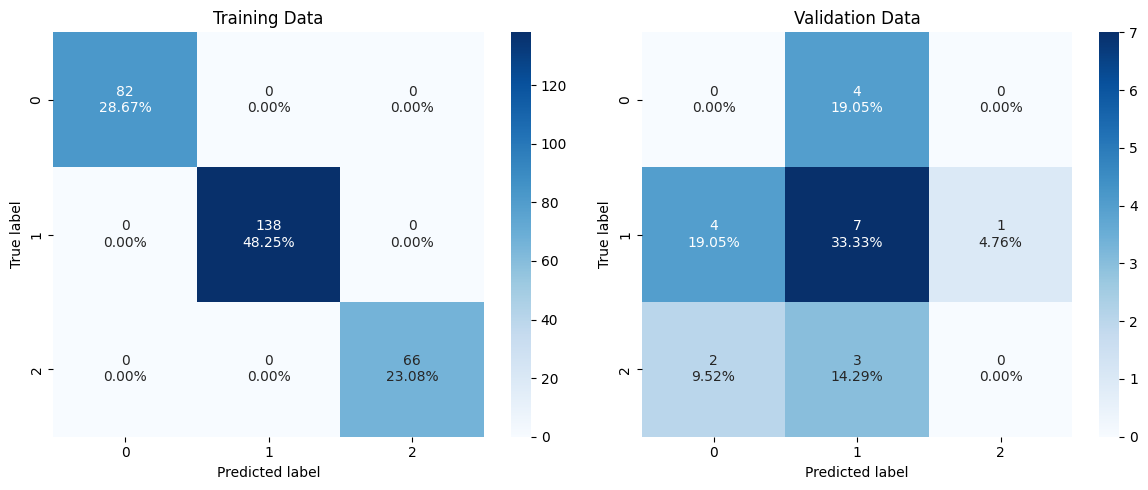

In [ ]:
confusion_matrix_train_val(model_wv,X_train_wv,y_train, X_val_wv,y_val)

In [ ]:
base_wv_perf=model_metrics_train_val(model_wv,X_train_wv,y_train, X_val_wv,y_val)
base_wv_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.333333,0.333333,0.285714,0.307692


* We can clearly see that the model is overfitting

###Base model Glove

In [ ]:
model_gl=XGBClassifier(tree_method='gpu_hist',random_state=2, eval_metric='logloss')
model_gl.fit(X_train_gl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

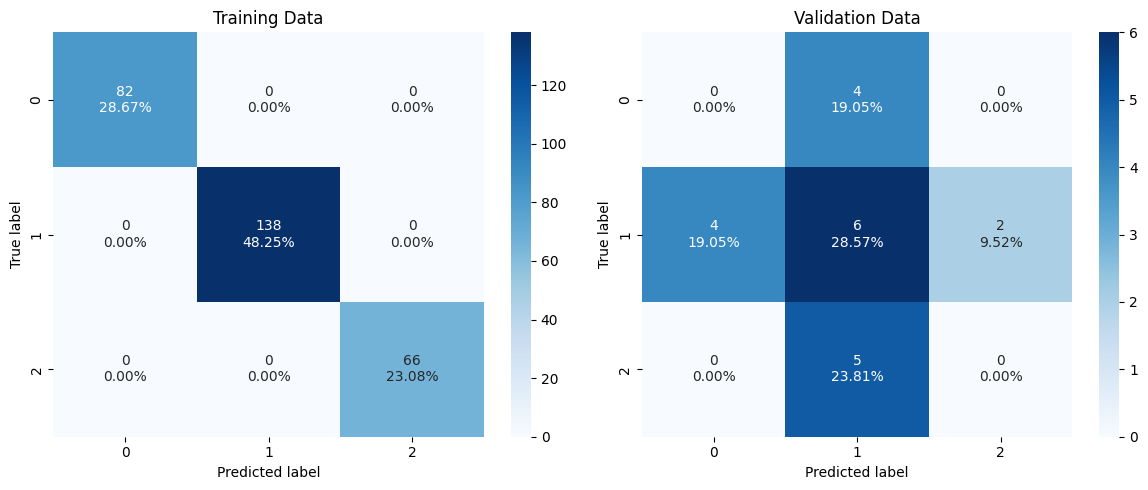

In [ ]:
confusion_matrix_train_val(model_gl,X_train_gl,y_train, X_val_gl,y_val)

In [ ]:
base_gl_perf=model_metrics_train_val(model_gl,X_train_gl,y_train, X_val_gl,y_val)
base_gl_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.285714,0.285714,0.228571,0.253968


* When using Glove the model is also very overfit, the scores on the validation set are lower than when using Word2Vec

###Base model Sentence Transformer

In [ ]:
model_st=XGBClassifier(tree_method='gpu_hist', random_state=2, eval_metric='logloss')
model_st.fit(X_train_st,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

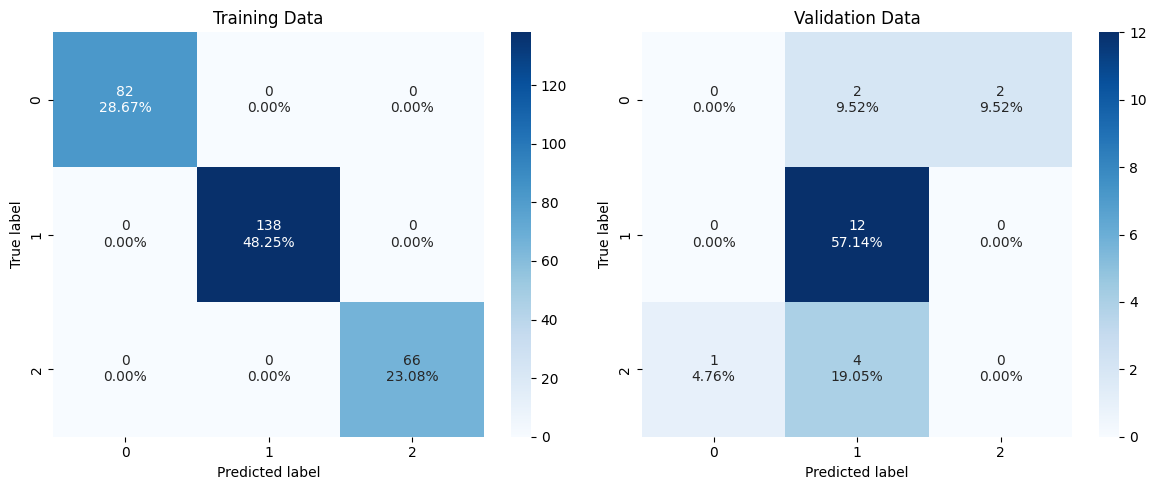

In [ ]:
confusion_matrix_train_val(model_st,X_train_st,y_train, X_val_st,y_val)

In [ ]:
base_st_perf=model_metrics_train_val(model_st,X_train_st,y_train, X_val_st,y_val)
base_st_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.571429,0.571429,0.380952,0.457143


* The model is also overfit but the scores on the validation set are higher than for the previous 2 models

###Tuning Word2Vec model

In [ ]:
start = time.time()
tuned_wv=XGBClassifier(tree_method='gpu_hist', random_state=2, eval_metric='logloss')

parameters = {
    'n_estimators':[50,70,100,125],
    'scale_pos_weight':[1,2,5],
    'learning_rate':[0.01,0.1,0.03],
    'max_depth': [3,5,7,10],
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,verbose=2,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)
end = time.time()
print("Time taken ",(end-start))

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))
# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Time taken  4517.183821439743
Best parameters are {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 50, 'scale_pos_weight': 1} with CV score=0.4796432450909947:


In [ ]:
tuned_wv.fit(X_train_wv, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_features='log2', max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None, ...)

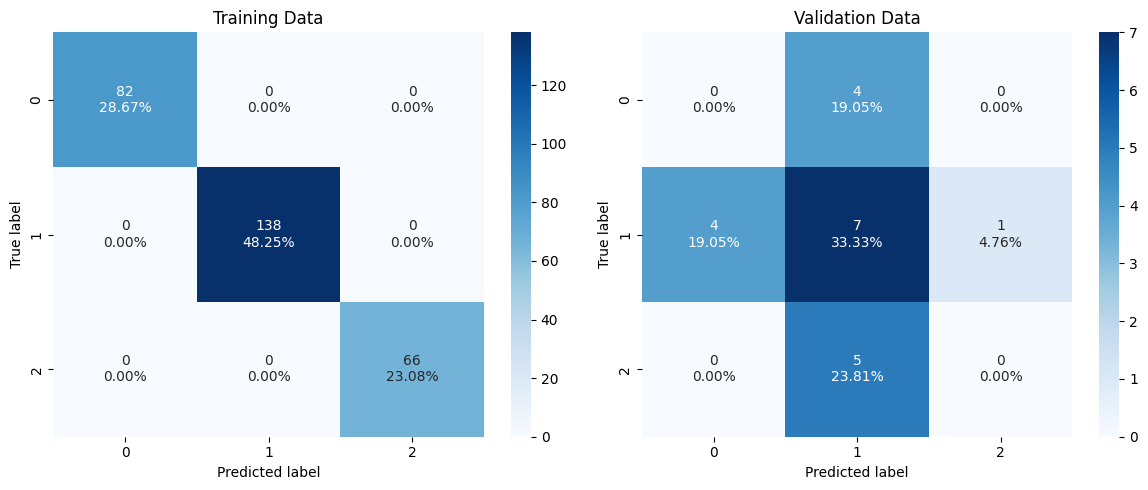

In [ ]:
confusion_matrix_train_val(tuned_wv,X_train_wv,y_train, X_val_wv,y_val)

In [ ]:
tuned_wv_perf=model_metrics_train_val(tuned_wv,X_train_wv,y_train, X_val_wv,y_val)
tuned_wv_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.00,1.000000
Validation data,0.333333,0.333333,0.25,0.285714


* Tuning did not help in this case, rather actually made the validation set scores worse

###Tuning Glove

In [ ]:
start = time.time()
tuned_gl=XGBClassifier(tree_method='gpu_hist', random_state=2, eval_metric='logloss')

parameters = {
    'n_estimators':[50,70,100,125],
    'learning_rate':[0.01,0.1,0.03],
    'max_depth': [3,5,7,10],
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))
print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))
# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  1488.6497068405151
Best parameters are {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50} with CV score=0.49812415524717313:


In [ ]:
tuned_gl.fit(X_train_gl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_features='log2', max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None, ...)

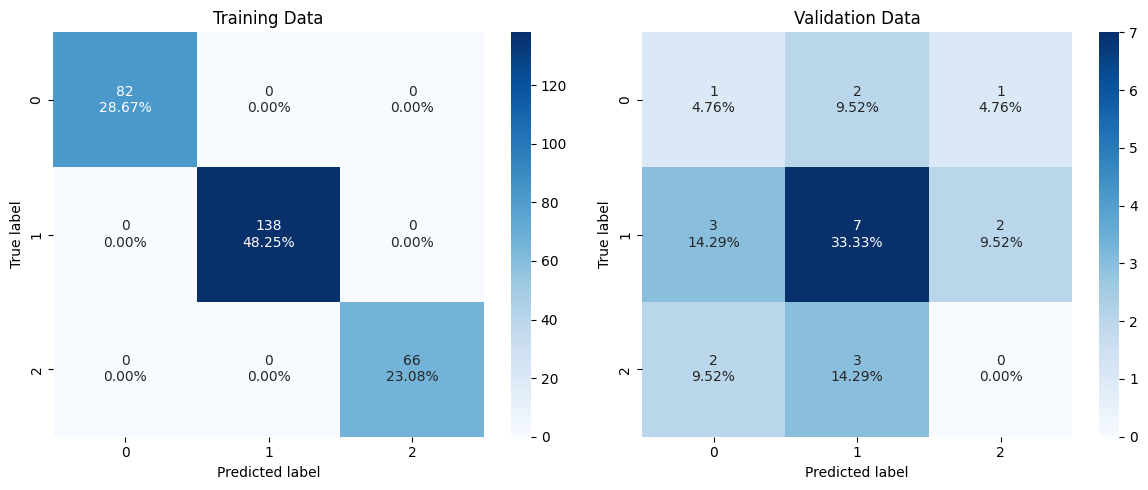

In [ ]:
confusion_matrix_train_val(tuned_gl,X_train_gl,y_train, X_val_gl,y_val)

In [ ]:
tuned_gl_perf=model_metrics_train_val(tuned_gl,X_train_gl,y_train, X_val_gl,y_val)
tuned_gl_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.000000,1.000000
Validation data,0.380952,0.380952,0.365079,0.371429


* In this case tuned model have improved performance compared to the base Glove model

### Tuning Sentence transformer

In [ ]:
start = time.time()
tuned_st=XGBClassifier(tree_method='gpu_hist', random_state=2, eval_metric='logloss')

parameters = {
    'n_estimators':[50,70,100,125],
    'learning_rate':[0.01,0.1,0.03],
    'max_depth': [3,5,7,10],
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))
print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))
# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  1490.4348587989807
Best parameters are {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 125} with CV score=0.45164889997490876:


In [ ]:
tuned_st.fit(X_train_st,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_features='log2', max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None, ...)

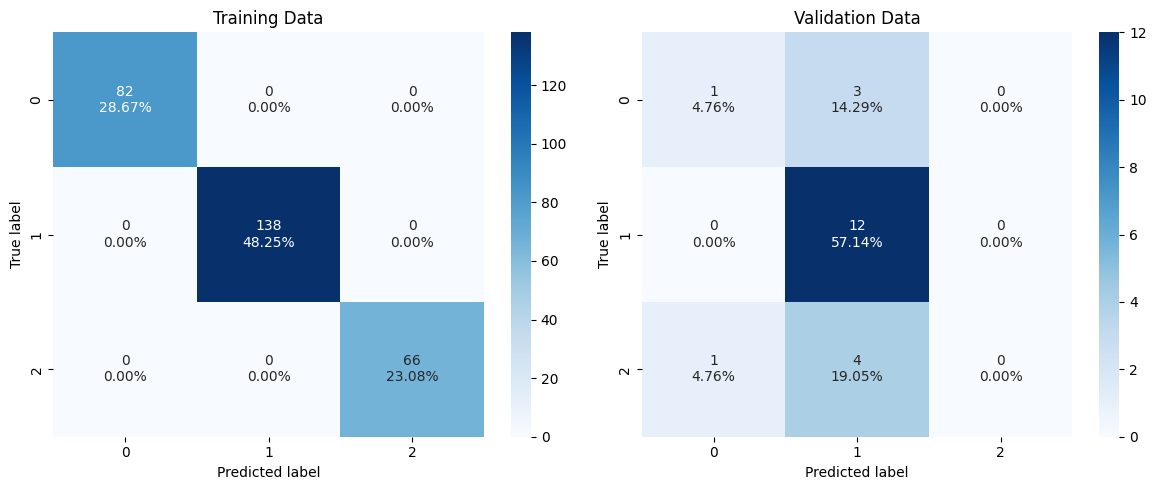

In [ ]:
confusion_matrix_train_val(tuned_st,X_train_st,y_train, X_val_st,y_val)

In [ ]:
tuned_st_perf=model_metrics_train_val(tuned_st,X_train_st,y_train, X_val_st,y_val)
tuned_st_perf

,Accuracy,Recall,Precision,F1
Training data,1.000000,1.000000,1.00000,1.000000
Validation data,0.619048,0.619048,0.45614,0.505888


* Tuning Sentence Transformer model also helped to improve the scores

###Model comparison

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        base_wv_perf.iloc[0,:].T,
        base_gl_perf.iloc[0,:].T,
        base_st_perf.iloc[0,:].T,
        tuned_wv_perf.iloc[0,:].T,
        tuned_gl_perf.iloc[0,:].T,
        tuned_st_perf.iloc[0,:].T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Base Word2Vec",
    "Bsed Glove",
    "Base Sentence Transformer",
    "Tuned Word2Vec",
    "Tuned Glove",
    "Tuned Sentence Transformer"
]

In [ ]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        base_wv_perf.iloc[1,:].T,
        base_gl_perf.iloc[1,:].T,
        base_st_perf.iloc[1,:].T,
        tuned_wv_perf.iloc[1,:].T,
        tuned_gl_perf.iloc[1,:].T,
        tuned_st_perf.iloc[1,:].T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Base Word2Vec",
    "Bsed Glove",
    "Base Sentence Transformer",
    "Tuned Word2Vec",
    "Tuned Glove",
    "Tuned Sentence Transformer"
]

In [ ]:
#Results on training dataset
models_train_comp_df

,Base Word2Vec,Bsed Glove,Base Sentence Transformer,Tuned Word2Vec,Tuned Glove,Tuned Sentence Transformer
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Results on validation dataset
models_val_comp_df

,Base Word2Vec,Bsed Glove,Base Sentence Transformer,Tuned Word2Vec,Tuned Glove,Tuned Sentence Transformer
Accuracy,0.333333,0.285714,0.571429,0.333333,0.380952,0.619048
Recall,0.333333,0.285714,0.571429,0.333333,0.380952,0.619048
Precision,0.285714,0.228571,0.380952,0.250000,0.365079,0.456140
F1,0.307692,0.253968,0.457143,0.285714,0.371429,0.505888


* The tuned Sentence Transformer model shows the best performance, even though it is still overfit. I am choosing it as the best model.

###Checking performance of the best model on the test data

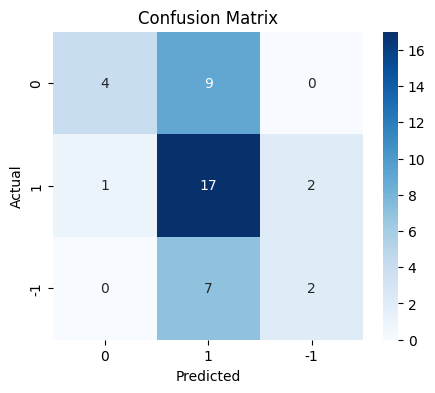

In [ ]:
plot_confusion_matrix(tuned_st, X_test_st, y_test)

In [ ]:
model_performance_classification_sklearn(tuned_st, X_test_st, y_test)

,Accuracy,Recall,Precision,F1
0,0.547619,0.547619,0.600072,0.508981


* On the test set the chosen model shows performance similar to the validation set

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DGGML_CUDA=on" FORCE_CMAKE=1

In [ ]:
!pip install llama-cpp-python

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stock=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 6/stock_news.csv')
data=stock.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=32768, #Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [ ]:
#Converting the Date column to datetime format
data["Date"] = pd.to_datetime(data['Date'])

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

###Summarization

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=2096,
      repeat_penalty=1.2,
      temperature=0.1,
      top_k=50,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
prompt = """You are an expert financial analyst equipped with a deep understanding of stock markets and their dynamics.
Your task is to summarize a set of stock-related news articles from a given week to provide actionable insights for investors.
Analyze the news and identify 3 most impactful positive events and 3 most impactful negative events that are likely to affect the stock price of the company.
For each event, clearly state a concise description of the event.

Input Structure:
You will be provided with a list of news articles from the week (the content of the articles).

Output Format:
Return your summary in the following JSON format:

json
{
    "Positive Events": [
        {
            "Event 1": "Concise description of the event."
        },
        {
            "Event 2": "Concise description of the event."
        },
        {
            "Event 3": "Concise description of the event."
        }
    ],
    "Negative Events": [
        {
            "Event 1": "Concise description of the event."
        },
        {
            "Event 2": "Concise description of the event."
        },
        {
            "Event 3": "Concise description of the event."
        }
    ]
}

Constraints:
Use a professional tone appropriate for financial analysis.
Now, analyze the weekly news articles provided below and return the output in the format specified above.
"""

In [ ]:
%%time
summary=response_mistral(prompt,news)
print(summary)

llama_perf_context_print:        load time =  333501.90 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4093 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   424 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  424922.91 ms /  4517 tokens


 json
      {
          "Positive Events": [
              {
                  "Event 1": "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel. This follows Amazon's successful Channels business model."
              },
              {
                  "Event 2": "The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending to help boost China's economy amid slowing domestic demand and U.S. tariffs."
              },
              {
                  "Event 3": "The Supreme Court will review Broadcom's appeal in a shareholder lawsuit over the 2015 acquisition of Emulex, which could extend beyond the Broadcom suit and have implications for similar cases."
              }
          ],
          "Negative Events": [
              {
                  "Event 1": "Apple cut its fiscal first quarter revenue foreca

* We received a proper formated Json from the model, containing the news of the proper sentiment

##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 176 prefix-match hit, remaining 3917 prompt tokens to eval
llama_perf_context_print:        load time =  333501.90 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3917 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   420 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  411979.33 ms /  4337 tokens
 11%|█         | 2/18 [06:51<54:55, 206.00s/it]Llama.generate: 348 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =  333501.90 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   306 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  237191.97 ms /  2540 to

CPU times: user 8h 19min 20s, sys: 10.8 s, total: 8h 19min 31s
Wall time: 52min 25s


##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"json\n {\n ""Positive Events"": [...",{'Positive Events': [{'Event 1': 'Roku Inc ann...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"json\n {\n ""Positive Events"": [...",{'Positive Events': [{'Event 1': 'Sprint and S...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"json\n {\n ""Positive Events"": [...",{'Positive Events': [{'Event 1': 'Apple announ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","json\n {\n ""Positive Events"": [...",{'Positive Events': [{'Event 1': 'IBM reported...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"json\n {\n ""Positive Events"": [...",{'Positive Events': [{'Event 1': 'Apple report...


In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,[{'Event 1': 'Roku Inc announced plans to offe...,[{'Event 1': 'Apple cut its fiscal first quart...
1,[{'Event 1': 'Sprint and Samsung's plan to rel...,[{'Event 1': 'Geely forecasting flat sales for...
2,[{'Event 1': 'Apple announced a price increase...,[{'Event 1': 'Unexpected drops in China's expo...
3,[{'Event 1': 'IBM reported better-than-expecte...,[{'Event 1': 'Swiss National Bank governor And...
4,[{'Event 1': 'Apple reported spending over $60...,[{'Event 1': 'Caterpillar Inc reported lower-t...


In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[{'Event 1': 'Roku Inc announced plans to offe...,[{'Event 1': 'Apple cut its fiscal first quart...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[{'Event 1': 'Sprint and Samsung's plan to rel...,[{'Event 1': 'Geely forecasting flat sales for...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[{'Event 1': 'Apple announced a price increase...,[{'Event 1': 'Unexpected drops in China's expo...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[{'Event 1': 'IBM reported better-than-expecte...,[{'Event 1': 'Swiss National Bank governor And...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[{'Event 1': 'Apple reported spending over $60...,[{'Event 1': 'Caterpillar Inc reported lower-t...


* It was possible to parse all the replies we received from the model - which means the reply was structured properly according to the used prompt.

##Weekly summary different model

###Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DGGML_CUDA=on" FORCE_CMAKE=1

In [ ]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 MB 32.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.2-cp310-cp310-linux_x86_64.whl size=3447044 sha256=c40473ee60e5e85271294aba090d30911769eced3f63700b6abbc4c880c5a721
  Stored in directory: /root/.cache/pip/wheels/49/1c/f0/6c1ed6032d5827dea28df8a8df860d90ca1bcd7b3fa455f5e1
Successfully built llama-cpp-python


In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

###Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 6/stock_news.csv')
data1=stock.copy()

###Loading the model

In [ ]:
model_name_or_path = "TheBloke/dolphin-2.0-mistral-7B-GGUF"
model_basename = "dolphin-2.0-mistral-7b.Q5_K_S.gguf"

model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dolphin-2.0-mistral-7b.Q5_K_S.gguf:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=32768, #Context window
)

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--dolphin-2.0-mistral-7B-GGUF/snapshots/3b345ee148d25b2da209c6166e855dc4845fcb4e/dolphin-2.0-mistral-7b.Q5_K_S.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = ehartford_dolphin-2.0-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6: 

###Aggregating the data weekly

In [ ]:
data1["Date"] = pd.to_datetime(data1['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped1 = data1.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped1 = weekly_grouped1.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped1.shape)

(18, 2)


In [ ]:
weekly_grouped1

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data2 = weekly_grouped1.copy()

###Summarization

####Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

####Defining the response function

In [ ]:
# Simple inference example
def response_dolphin(prompt, news):
    output = llm(
      f"""
      <|im_start|>
      user\n
      {prompt}\n
      News Articles: {news}
      <|im_end|>\n
      <|im_start|>
      assistant
      """,
      max_tokens=2048,  # Generate up to 2048 tokens
      temperature=0,
      repeat_penalty=1.2,
      top_k=50,
      echo=False        # Whether to echo the prompt
    )

    final_output = output["choices"][0]["text"]

    return final_output

####Checking the model output on a sample

In [ ]:
news = data2.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
prompt = """You are an expert financial analyst equipped with a deep understanding of stock markets and their dynamics.
Your task is to summarize a set of stock-related news articles from a given week to provide actionable insights for investors.
Analyze the news and identify 3 most impactful positive events and 3 most impactful negative events that are likely to affect the stock price of the company.
For each event, clearly state a concise description of the event.

Input Structure:
You will be provided with a list of news articles from the week (the content of the articles).

Output Format:
Return your summary in the following JSON format:

json
{
    "Positive Events": [
        {
            "Event 1": "Concise description of the event."
        },
        {
            "Event 2": "Concise description of the event."
        },
        {
            "Event 3": "Concise description of the event."
        }
    ],
    "Negative Events": [
        {
            "Event 1": "Concise description of the event."
        },
        {
            "Event 2": "Concise description of the event."
        },
        {
            "Event 3": "Concise description of the event."
        }
    ]
}

Constraints:
Use a professional tone appropriate for financial analysis.
Now, analyze the weekly news articles provided below and return the output in the format specified above.
"""

In [ ]:
%%time
summary = response_dolphin(prompt, news)
print(summary)

Llama.generate: 11 prefix-match hit, remaining 4107 prompt tokens to eval
llama_perf_context_print:        load time =  394855.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4107 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   415 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  474770.66 ms /  4522 tokens



      Positive Events: [
        {
          "Event 1": "Apple's Q1 revenue guidance cut due to weaker demand in China and fewer iPhone upgrades led to a significant drop in Apple's stock price, negatively impacting related suppliers."
        },
        {
          "Event 2": "The global economic slowdown following weak economic data from China and Europe as well as the partial U.S. government shutdown contributed to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency."
        },
        {
          "Event 3": "Roku announced plans to offer premium video channels on a subscription basis through its free streaming service, following Amazon's successful Channels business. This model is expected to generate significant interest and potentially boost Roku's revenue."
        }
      ],
      
      Negative Events: [
        {
          "Event 1": "Apple's Q1 revenue guidance cut from $89-$93 billion to $84 billion due to weaker

* We got news properly divided by the sentiment in response, however the json is not properly formatted

####Checking the model output on the weekly data

In [ ]:
%%time
data2['Key Events'] = data2['News'].progress_apply(lambda x: response_dolphin(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 4117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =  394855.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   392 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   80274.67 ms /   393 tokens
 11%|█         | 2/18 [01:20<10:42, 40.15s/it]Llama.generate: 357 prefix-match hit, remaining 2250 prompt tokens to eval
llama_perf_context_print:        load time =  394855.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2250 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   348 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  272463.62 ms /  2598 token

CPU times: user 7h 55min 47s, sys: 9.52 s, total: 7h 55min 56s
Wall time: 48min 30s


####Formatting the model output

In [ ]:
data2['model_response_parsed'] = data2['Key Events'].apply(extract_json_data)
data2.head()

Error parsing JSON: Extra data: line 3 column 10 (char 212)
      You are an expert financial analyst equipped with a deep understanding of stock markets and their dynamics. Your task is to summarize a set of stock-related news articles from the week (the content of the articles). Analyze the news and identify 3 most impactful positive events and 3 most impactful negative events that are likely to affect the stock price of the company. For each event, clearly state a concise description of the event.

Error parsing JSON: Extra data: line 3 column 10 (char 127)
Error parsing JSON: Extra data: line 3 column 10 (char 212)
      The positive events for this week are:
      1. Spotify reported better-than-expected Q1 revenue growth, reaching 100 million paid subscribers despite increasing competition from Apple Music, Amazon, and Google. This indicates a strong user base and potential for further expansion in emerging markets.
      2. The S&P 500 reached a new intraday record high on Monda

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,\n Positive Events: [\n {\n ...,{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,\n You are an expert financial analyst pr...,{'Positive Events': [{'Event 1': 'Sprint and S...
2,2019-01-20,The U.S. stock market declined on Monday as c...,\n You are an expert financial analyst wh...,{'Positive Events': [{'Event 1': 'Concise desc...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",\n You are an expert financial analyst pr...,{'Positive Events': [{'Event 1': 'IBM's stock ...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,\n You are an expert financial analyst eq...,{}


In [ ]:
model_response_parsed1 = pd.json_normalize(data2['model_response_parsed'])
model_response_parsed1.head()

,Positive Events,Negative Events
0,NaN,NaN
1,[{'Event 1': 'Sprint and Samsung plan to relea...,"[{'Event 1': 'Geely, China's most successful c..."
2,[{'Event 1': 'Concise description of the event...,[{'Event 1': 'Concise description of the event...
3,[{'Event 1': 'IBM's stock price increased afte...,[{'Event 2': 'Switzerland's SNB governor Andre...
4,NaN,NaN


In [ ]:
final_output1 = pd.concat([data2.reset_index(drop=True),model_response_parsed1],axis=1)
final_output1.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output1.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output1.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[{'Event 1': 'Sprint and Samsung plan to relea...,"[{'Event 1': 'Geely, China's most successful c..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,[{'Event 1': 'Concise description of the event...,[{'Event 1': 'Concise description of the event...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[{'Event 1': 'IBM's stock price increased afte...,[{'Event 2': 'Switzerland's SNB governor Andre...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,NaN,NaN


* The second model we tried got a worse result - the response was not a properly formatted json, even though the list of returned news seems to be correct

## **Conclusions and Recommendations**

* I believe it is necessary to doule-check the dataset once again.
We can observe that the minimum value for the 'Close' column is lower than the minimum value for the 'Low' column, which seems strange, it should be discussed with the domain expert.

* Additionally, we saw that the content of the news articles present in the dataset was truncated - which may negatively influence the results of both the semantic analisys and the summarization. If it is possible the full content should be used.

* From the EDA we observed regular and significant drops in prices, which do not appear to correlate completely with the news that are printed regarding the company. I believe this should be further analysed with the help of a domain expert.

* Also, the dataset is not very large - if possible, it would be good to try training the models for semantic analysis on a larger dataset.

* The models that we used showed overfit - further tuning is adviced, as well as trying other classifiers. We could try regularization, other ensemble techniques. We could also try data augmentation.

* From the 2 models that were tried for weekly summarization Mistral-7B-Instruct-v0.2-GGUF showed better results, and the used prompt appears to do the job.